In [1]:
import sys
import os

# Step 1: Compute the path 3 levels up from the current working directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../" * 3))

# Step 2: Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 3: Now you can import your module
import qf
import matplotlib.pyplot as plt
import numpy as np

/Users/PhilippSchmidt/miniforge3/envs/finrl-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "NFLX"]
#tickers = qf.DOWJONES

data = qf.get_data(tickers, 
                   start=qf.DEFAULT_TRAIN_START, 
                   end=qf.DEFAULT_TRAIN_END, 
                   indicators=["close"],
                   imputation_method="shrinkage",
                   n_trading_days=252)
data.head(10)

,AAPL,GOOGL,MSFT,AMZN,TSLA,NFLX
,Close,Close,Close,Close,Close,Close
2010-06-29,7.698982,11.300098,17.642700,5.4305,1.592667,16.082857
2010-06-30,7.559530,11.068503,17.415646,5.4630,1.588667,15.521429
2010-07-01,7.467865,10.932680,17.529169,5.5480,1.464000,15.665714
2010-07-02,7.421582,10.859547,17.612427,5.4570,1.280000,15.297143
2010-07-06,7.472372,10.847607,18.028711,5.5030,1.074000,15.324286
2010-07-07,7.774117,11.199102,18.392000,5.6715,1.053333,16.927143
2010-07-08,7.756684,11.357311,18.475262,5.8110,1.164000,16.711430
2010-07-09,7.802667,11.629205,18.369295,5.8630,1.160000,16.790001
2010-07-12,7.732640,11.836670,18.793154,5.9755,1.136667,17.054285


<Axes: title={'center': 'Close Price of All Tickers'}, xlabel='Date', ylabel='Price'>

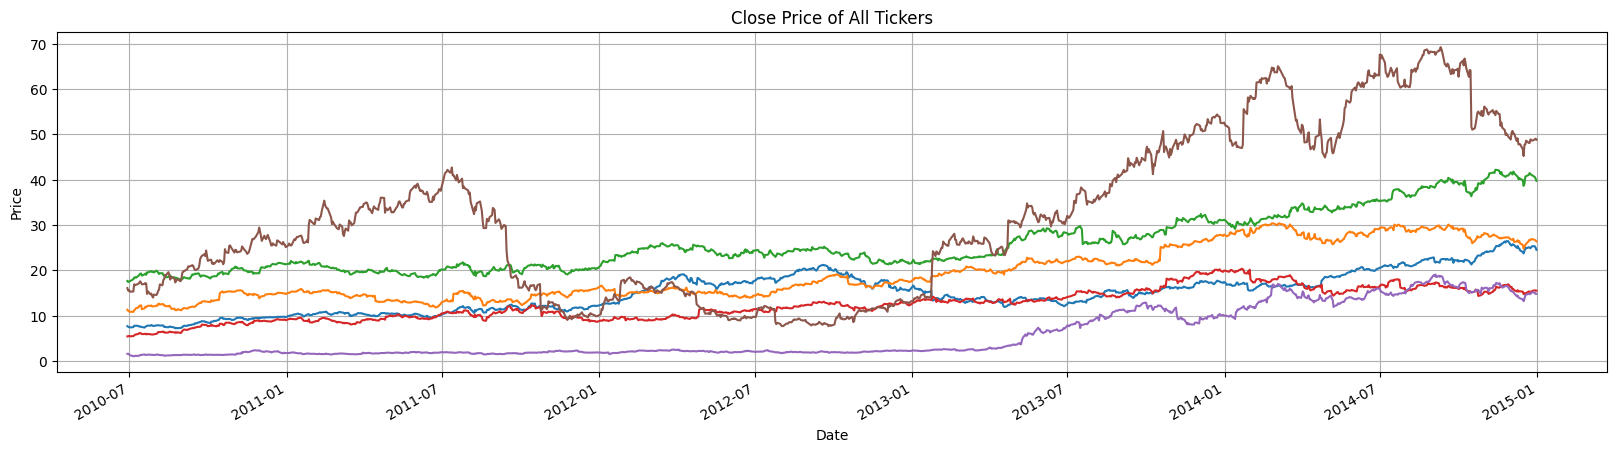

In [20]:
data.plot(figsize=(20, 5), title="Close Price of All Tickers", ylabel="Price", xlabel="Date", grid=True, legend=False)

In [21]:
# Calculate log returns
returns = data.pct_change().dropna()
log_returns = data.pct_change().apply(lambda x: np.log(1 + x)).dropna()

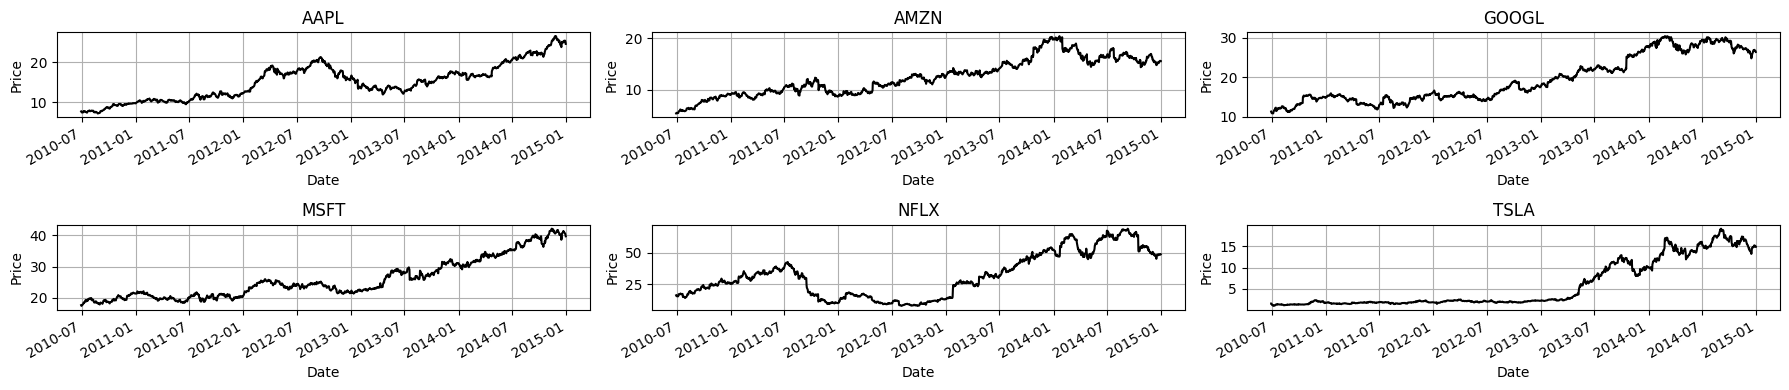

In [ ]:
qf.plot_grid(data)
qf.plot_grid(returns, n_cols=3, ylim=(-0.1, 0.1), figsize=(6, 2))
qf.plot_hist_grid(returns, n_cols=3, bins=50, figsize=(6, 2), log_y_scale=False)

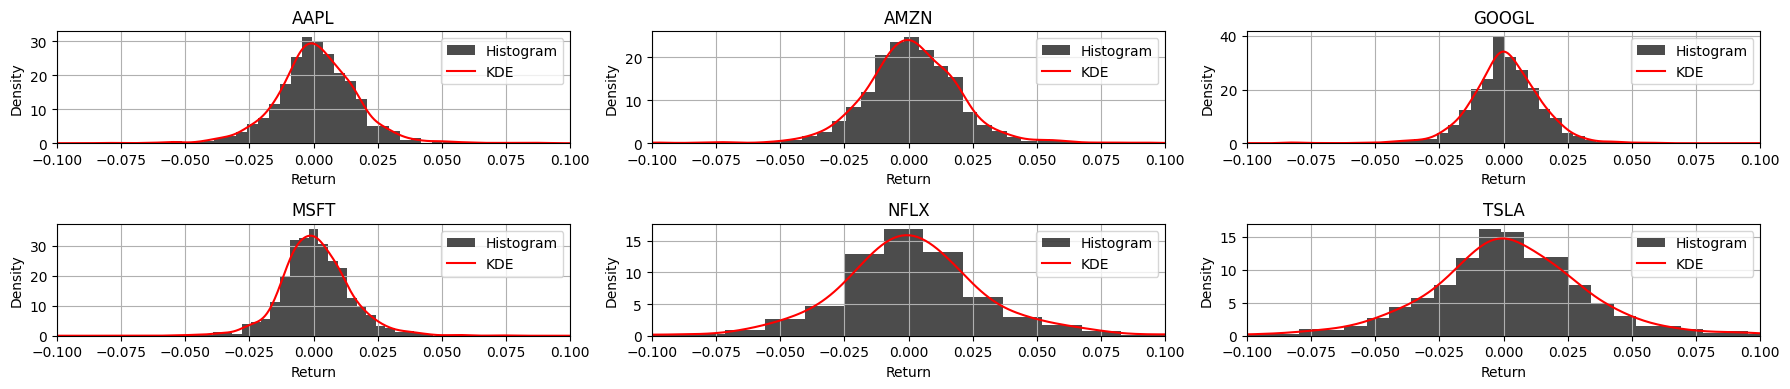

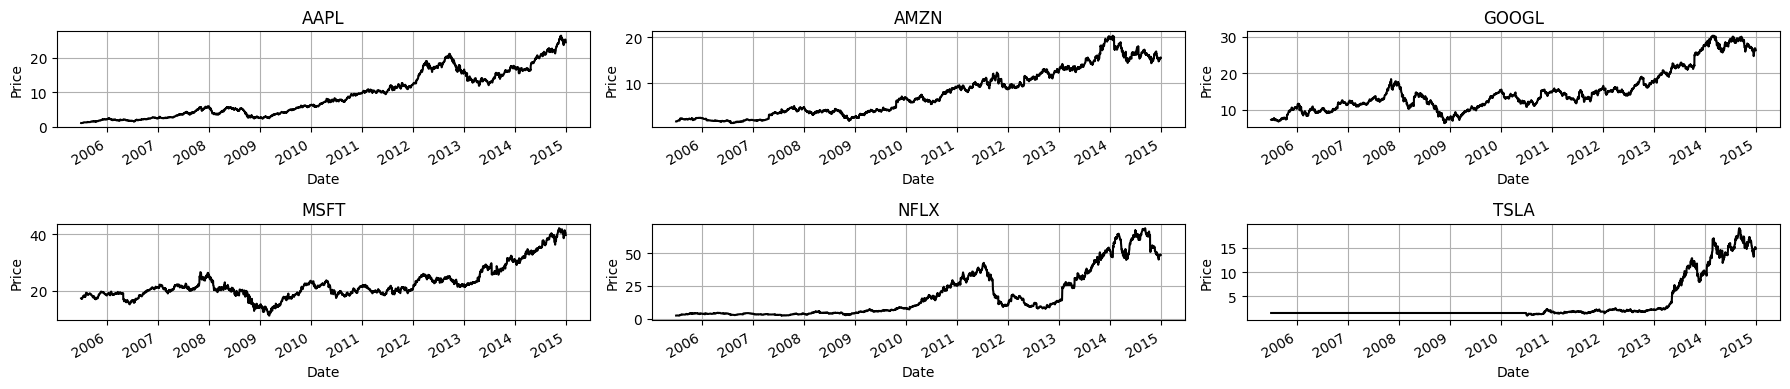

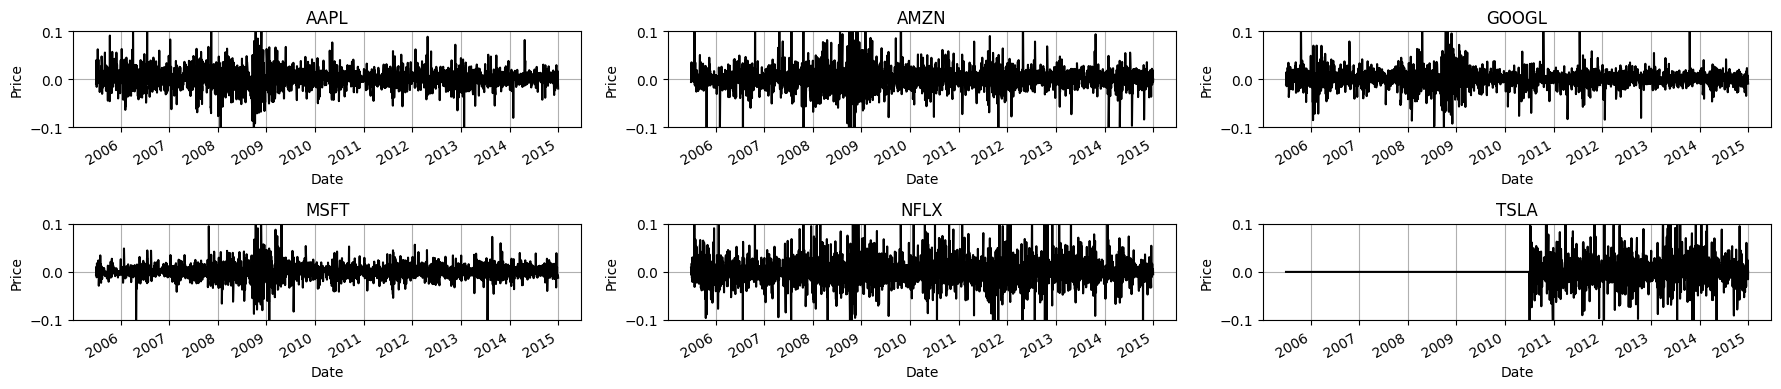

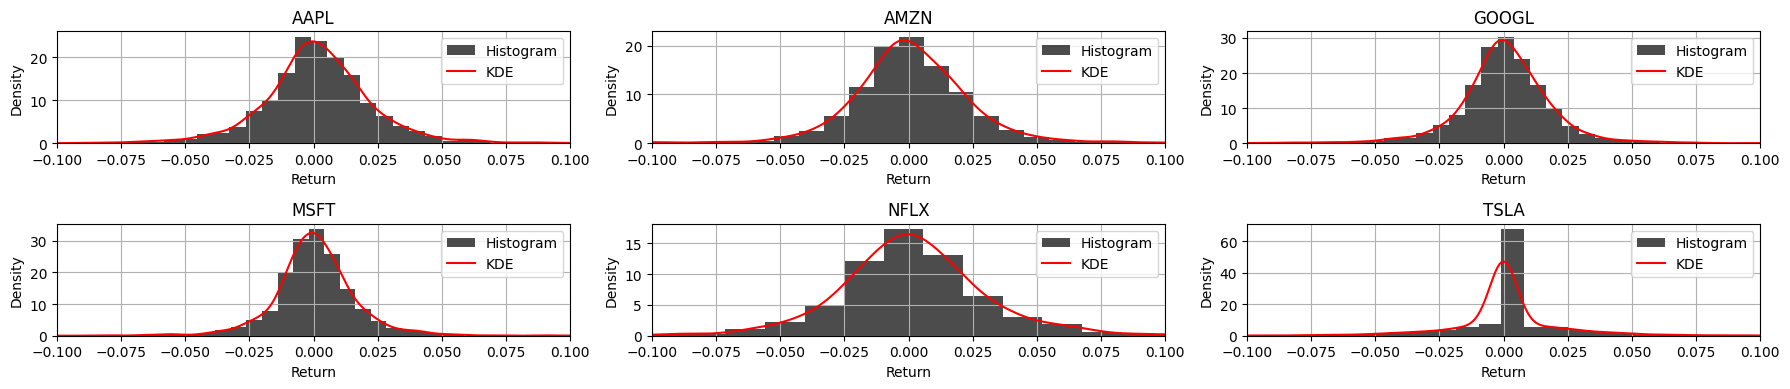

In [25]:
# Now we want to compare the statistics of the returns of the tickers if we use 
prices_bfill = qf.get_data(tickers, 
            start=qf.DEFAULT_TRAIN_START, 
            end=qf.DEFAULT_TRAIN_END, 
            indicators="close", 
            imputation_method="bfill",
            n_trading_days=252)

returns_bfill = prices_bfill.pct_change().dropna()
log_returns_bfill = prices_bfill.pct_change().apply(lambda x: np.log(1 + x)).dropna()


qf.plot_grid(prices_bfill)

qf.plot_grid(returns_bfill, n_cols=3, ylim=(-0.1, 0.1), figsize=(6, 2))

qf.plot_hist_grid(returns_bfill, n_cols=3, bins=50, figsize=(6, 2), log_y_scale=False)


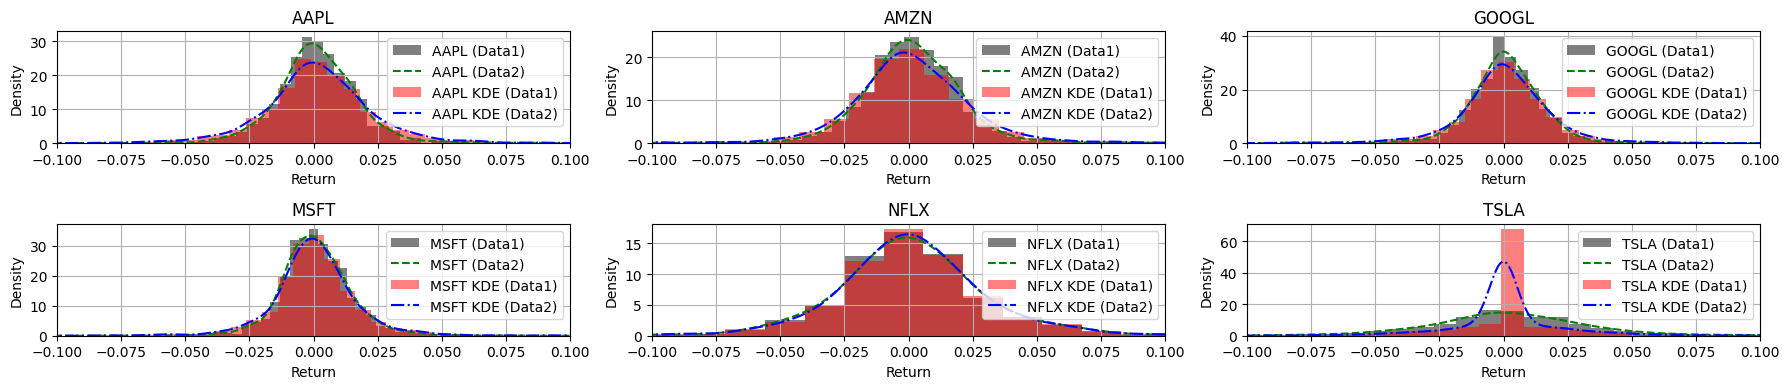

In [26]:
qf.plot_hist_grid_compare(returns, returns_bfill,
                          n_cols=3, bins=50, figsize=(6, 2))

In [10]:
# Calculate and compare the statistics of the returns
def calculate_statistics(returns):
    stats = {
        'mean': returns.mean(),
        'std': returns.std(),
        'skew': returns.skew(),
        'kurtosis': returns.kurtosis()
    }
    return stats

stats = calculate_statistics(log_returns)
stats_bfill = calculate_statistics(log_returns_bfill)

import pandas as pd

# Now stats is a dictionary of multiindex dataframes
# Make a new level in the index for the statistics
stats_df = pd.DataFrame(stats).T
stats_bfill_df = pd.DataFrame(stats_bfill).T

error = stats_df - stats_bfill_df

# Absoluter Fehler
abs_error = (stats_df - stats_bfill_df).abs()

# Relativer Fehler nur für std
rel_error_std = abs_error.loc['std'] / stats_df.loc['std']

In [11]:
abs_error

,AAPL,AMZN,BA,CAT,CSCO,CVX,DIS,GS,HON,IBM,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
skew,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
kurtosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


In [12]:


# Bewertung
tolerable = {
    'mean': abs_error.loc['mean'] < 1e-4,
    'std': rel_error_std < 0.01,
    'skew': abs_error.loc['skew'] < 0.1,
    'kurtosis': abs_error.loc['kurtosis'] < 0.5
}

# Überblick
tolerable_df = pd.DataFrame(tolerable)
print(tolerable_df)

             mean    std   skew  kurtosis
AAPL Close   True   True   True      True
AMZN Close   True   True   True      True
BA   Close   True   True   True      True
CAT  Close   True   True   True      True
CSCO Close   True   True   True      True
CVX  Close   True   True   True      True
DIS  Close   True   True   True      True
GS   Close   True   True   True      True
HON  Close   True   True   True      True
IBM  Close   True   True   True      True
JNJ  Close   True   True   True      True
KO   Close   True   True   True      True
MCD  Close   True   True   True      True
MRK  Close   True   True   True      True
MSFT Close   True   True   True      True
NKE  Close   True   True   True      True
NVDA Close   True   True   True      True
PG   Close   True   True   True      True
SHW  Close   True   True   True      True
TRV  Close   True   True   True      True
UNH  Close   True   True   True      True
V    Close  False  False  False     False
VZ   Close   True   True   True   